In [1]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import h5py
import logging
import numpy as np
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
import scipy.stats as stats
import os.path
import gc
import os
import seaborn as sns
%matplotlib inline



INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
process_type='inter'

species='mouse'
SRP_name='aggregates'
resolution='1kbp_raw'
base_folder='/grid/gillis/data_norepl/lohia'

In [3]:
cell_type_map = {'VLMC' : 'VLMC' ,
'Micro-PVM' : 'MGC' ,
'Astro' : 'ASC' ,
'L2/3 IT' : 'L2_3_IT' ,
'L5 IT' : 'L5_IT' ,
'Oligo' : 'ODC' ,
'Sst' : 'SST' ,
'Pvalb' : 'PVALB' ,
'Vip' : 'VIP' ,
'Endo' : 'Endo' ,
'Lamp5' : 'LAMP5' ,
'Sncg' : 'SNCG' ,
'L5/6 NP' : 'L5_6_NP' ,
'L5 ET' : 'L5_ET' ,
'L6 CT' : 'L6_CT' ,
'L6b' :  'L6b' ,
'Sst Chodl' : 'SST' ,
'L6 IT' : 'L6_IT' 
}

df_marker = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/marker_all_info.csv')

df_marker = df_marker.drop_duplicates('group')

class_dict = dict(zip(df_marker.group, df_marker.classt))

df_atac_subclass_macs2 = pd.read_csv(f'/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/zemke_2023/Supplementary_Table_7.tsv', sep='\t')



df_atac_subclass_macs2['chr'] = [x.split('-')[0] for x in df_atac_subclass_macs2['coord']]
df_atac_subclass_macs2['st'] = [x.split('-')[1] for x in df_atac_subclass_macs2['coord']]
df_atac_subclass_macs2['end'] = [x.split('-')[2] for x in df_atac_subclass_macs2['coord']]
df_atac_subclass_macs2 = df_atac_subclass_macs2[~df_atac_subclass_macs2['chr'].isin(['chrX', 'chrY'])]
df_atac_subclass_macs2['chr_num'] = [int(x.split('chr')[1]) for x in df_atac_subclass_macs2['chr']]
df_atac_subclass_macs2['ste'] = df_atac_subclass_macs2['st'].astype('int')
df_atac_subclass_macs2 = df_atac_subclass_macs2.sort_values(['chr_num', 'ste'])



df_list = []
for keyl in cell_type_map.keys():

    df_atac_subclass_macs2['gg'] = [1 if cell_type_map[keyl] in x else 0 for x in df_atac_subclass_macs2['celltype']]
    df = df_atac_subclass_macs2[df_atac_subclass_macs2['gg'] == 1]
    df['cell_type'] = keyl
    df_list.append(df[['chr', 'st', 'end', 'peak_id', 'cell_type']])
df_Zemke2023_label = pd.concat(df_list)

df_Zemke2023_label = df_Zemke2023_label.drop_duplicates()
b_dir = '/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/zemke_2023/'

df_Zemke2023_label.to_csv(f'{b_dir}/all_cre.bed', index=False, header=False, sep='\t')

os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b {b_dir}/all_cre.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed > {b_dir}/all_cre_bins.bed")

df_Zemke2023 = pd.read_csv(f'{b_dir}/all_cre_bins.bed', sep='\t', names=['chr', 'st', 'end', 'bin_id', 'p_chr', 'p_st', 'p_end', 'peak_label', 'cell_type', 'overlap' ])

df_Zemke2023['rank'] = 1

df_Zemke2023 = df_Zemke2023[df_Zemke2023['overlap'] > 250]



df_Zemke2023_table = df_Zemke2023.pivot_table(index='bin_id', columns='cell_type', values='rank', aggfunc='sum')

df_Zemke2023_table.fillna(0, inplace=True)

df_Zemke2023_table[df_Zemke2023_table != 0] = 1

df_Zu2023 = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/Zu_nature2023/subclass_manual.tsv', sep='\t')

df_Zu2023 = df_Zu2023.dropna(subset=['Metamarkers'])

b_dir = '/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/Zu_nature2023/cre_subclass/catlas.org/renlab_downloads/wholemousebrain/sa2.subclassv3.final.peak.srt'



df_list = []
for marker_label, name_label in zip(df_Zu2023['Metamarkers'].tolist()[:-1], df_Zu2023['subclass_label_peak'].tolist()[:-1]):
    df =  pd.read_csv(f'{b_dir}/{name_label}.bed', sep='\t', names=['chr', 'st', 'end', 'label'])
    df['cell_type'] =  marker_label
    df_list.append(df)
df_Zu2023_label = pd.concat(df_list)
                                    
                                    

df_Zu2023_label = df_Zu2023_label.drop_duplicates()

df_Zu2023_label.to_csv(f'{b_dir}/all_cre.bed', index=False, header=False, sep='\t')

os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b {b_dir}/all_cre.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed > {b_dir}/all_cre_bins.bed")

df_Zu2023 = pd.read_csv(f'{b_dir}/all_cre_bins.bed', sep='\t', names=['chr', 'st', 'end', 'bin_id', 'p_chr', 'p_st', 'p_end', 'peak_label', 'cell_type', 'overlap' ])

df_Zu2023['rank'] = 1

df_Zu2023 = df_Zu2023[df_Zu2023['overlap'] > 250]



df_Zu2023_table = df_Zu2023.pivot_table(index='bin_id', columns='cell_type', values='rank', aggfunc='sum')

df_Zu2023_table.fillna(0, inplace=True)

df_Zu2023_table[df_Zu2023_table != 0] = 1

df_Li2021 = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/Li2021_mouse_45sub/SupplementaryTable3Cellclusterannotation_manual.tsv', sep='\t')

df_Li2021 = df_Li2021.dropna(subset=['Metamarker'])

b_dir = '/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/Li2021_mouse_45sub/cell-type-cre/catlas.org/catlas_downloads/mousebrain/cCREs'

df_list = []
for marker_label, name_label in zip(df_Li2021['Metamarker'].tolist(), df_Li2021['Sub types'].tolist()):
    df =  pd.read_csv(f'{b_dir}/{name_label}.cCRE.bed', sep='\t', names=['chr', 'st', 'end', 'label'])
    df['cell_type'] =  marker_label
    df_list.append(df)
df_Li2021_label = pd.concat(df_list)

df_Li2021_label = df_Li2021_label.drop_duplicates()

df_Li2021_label.to_csv(f'{b_dir}/all_cre.bed', index=False, header=False, sep='\t')

os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b {b_dir}/all_cre.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed > {b_dir}/all_cre_bins.bed")

df_Li2021 = pd.read_csv(f'{b_dir}/all_cre_bins.bed', sep='\t', names=['chr', 'st', 'end', 'bin_id', 'p_chr', 'p_st', 'p_end', 'peak_label', 'cell_type', 'overlap' ])


df_Li2021['diff'] = [x-y if x>y else y-x for x,y in zip(df_Li2021['p_end'], df_Li2021['p_st'])]

df_Li2021['rank'] = 1

df_Li2021 = df_Li2021[df_Li2021['overlap'] > 250]



df_Li2021_table = df_Li2021.pivot_table(index='bin_id', columns='cell_type', values='rank', aggfunc='sum')

df_Li2021_table.fillna(0, inplace=True)

df_Li2021_table[df_Li2021_table != 0] = 1


bins_intersect_1 = df_Li2021_table.index.intersection(df_Zu2023_table.index)

df_meta_1 = df_Li2021_table.loc[bins_intersect_1, :]
bins_intersect = df_meta_1.index.intersection(df_Zemke2023_table.index)
df_meta_1 = df_Li2021_table.loc[bins_intersect, :]


df_meta_2 = df_Zu2023_table.loc[bins_intersect, :]

df_meta_3 = df_Zemke2023_table.loc[bins_intersect, :]

df_meta = pd.concat([df_meta_1.T, df_meta_2.T , df_meta_3.T])

df_meta = df_meta.T

<ipython-input-3-0b90d6e17892>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cell_type'] = keyl
<ipython-input-3-0b90d6e17892>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cell_type'] = keyl
<ipython-input-3-0b90d6e17892>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [18]:
df_meta = pd.concat([df_meta_1.T,  df_meta_2.T, df_meta_3.T])
df_meta_avg= df_meta.groupby(['cell_type']).mean().T

In [24]:
df_meta_1_prior = df_meta_1.mean(axis=1).reset_index()

In [26]:
df_meta_1_prior['sum'] = [1 if x>0 else 0 for x in df_meta_1_prior[0]]

In [29]:
df_meta_1_prior['sum'].min()

1

In [13]:
df_meta.T.groupby(['cell_type']).mean().T

cell_type     Astro      Endo   L2/3 IT  L4 IT  L4/5 IT  L5 ET     L5 IT  \
bin_id                                                                     
3112       0.000000  0.000000  0.000000    0.0      0.0    0.0  0.000000   
3113       0.000000  0.000000  0.333333    0.0      0.0    0.5  0.333333   
3119       0.000000  0.000000  1.000000    1.0      1.0    1.0  1.000000   
3120       0.000000  0.000000  1.000000    1.0      1.0    1.0  1.000000   
3121       0.333333  0.000000  1.000000    1.0      1.0    1.0  1.000000   
...             ...       ...       ...    ...      ...    ...       ...   
2462549    0.666667  0.666667  0.666667    1.0      1.0    1.0  0.666667   
2462550    1.000000  1.000000  1.000000    1.0      1.0    1.0  1.000000   
2462559    0.000000  0.000000  0.333333    0.0      1.0    0.0  0.333333   
2462567    0.333333  0.000000  0.000000    0.0      0.0    0.0  0.000000   
2462588    0.000000  0.000000  0.000000    0.0      0.0    0.0  0.000000   

cell_type  L5 PT  L5/6 NP     L6 CT  ...     Oligo  Peri     Pvalb  \
bin_id                               ...                             
3112         1.0      0.0  0.333333  ...  0.000000   0.0  0.666667   
3113         1.0      0.0  0.666667  ...  0.000000   0.0  0.333333   
3119         1.0      1.0  1.000000  ...  0.000000   0.0  0.333333   
3120         1.0      1.0  1.000000  ...  0.000000   0.0  1.000000   
3121         1.0      1.0  1.000000  ...  0.000000   0.0  1.000000   
...          ...      ...       ...  ...       ...   ...       ...   
2462549      1.0      1.0  0.666667  ...  0.666667   0.5  1.000000   
2462550      1.0      1.0  1.000000  ...  1.000000   0.5  1.000000   
2462559      0.0      0.0  0.333333  ...  0.000000   0.0  0.000000   
2462567      0.0      0.0  0.000000  ...  0.333333   0.0  0.000000   
2462588      0.0      0.0  0.000000  ...  1.000000   0.0  0.000000   

cell_type  Pvalb chandelier Gaba  SMC      Sncg       Sst  Sst Chodl  \
bin_id                                                                 
3112                         0.0  0.0  0.333333  0.333333   0.333333   
3113                         0.0  0.0  0.000000  0.000000   0.000000   
3119                         0.0  0.0  0.333333  1.000000   0.333333   
3120                         0.0  0.0  0.333333  1.000000   0.333333   
3121                         1.0  0.0  1.000000  1.000000   1.000000   
...                          ...  ...       ...       ...        ...   
2462549                      1.0  1.0  1.000000  1.000000   1.000000   
2462550                      1.0  1.0  1.000000  1.000000   1.000000   
2462559                      0.0  0.0  0.000000  0.000000   0.000000   
2462567                      0.0  0.0  0.000000  0.000000   0.000000   
2462588                      0.0  0.0  0.000000  0.000000   0.000000   

cell_type      VLMC       Vip  
bin_id                         
3112       0.000000  0.000000  
3113       0.000000  0.000000  
3119       0.333333  1.000000  
3120       0.000000  0.666667  
3121       0.333333  0.000000  
...             ...       ...  
2462549    1.000000  1.000000  
2462550    1.000000  1.000000  
2462559    0.000000  0.000000  
2462567    0.333333  0.000000  
2462588    0.000000  0.000000  

[239951 rows x 27 columns]

In [ ]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Oether']
dk = dj.groupby(['group']).mean()


features = dk.loc[:, pure_bins]


features = features.dropna(axis=0)

features = features.T

bins_intersect = df_meta.index.intersection(features.index)


df_meta_1 = df_Li2021_table.loc[bins_intersect, :]

df_meta_2 = df_Zu2023_table.loc[bins_intersect, :]

df_meta_3 = df_Zemke2023_table.loc[bins_intersect, :]

df_meta_4 = features.loc[bins_intersect, :]



In [ ]:
cell_type_map = {'VLMC' : 'VLMC' ,
'Micro-PVM' : 'MGC' ,
'Astro' : 'ASC' ,
'L2/3 IT' : 'L2_3_IT' ,
'L5 IT' : 'L5_IT' ,
'Oligo' : 'ODC' ,
'Sst' : 'SST' ,
'Pvalb' : 'PVALB' ,
'Vip' : 'VIP' ,
'Endo' : 'Endo' ,
'Lamp5' : 'LAMP5' ,
'Sncg' : 'SNCG' ,
'L5/6 NP' : 'L5_6_NP' ,
'L5 ET' : 'L5_ET' ,
'L6 CT' : 'L6_CT' ,
'L6b' :  'L6b' ,
'Sst Chodl' : 'SST' ,
'L6 IT' : 'L6_IT' 
}

df_marker = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/marker_all_info.csv')

df_marker = df_marker.drop_duplicates('group')

class_dict = dict(zip(df_marker.group, df_marker.classt))

df_atac_subclass_macs2 = pd.read_csv(f'/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/zemke_2023/Supplementary_Table_7.tsv', sep='\t')



df_atac_subclass_macs2['chr'] = [x.split('-')[0] for x in df_atac_subclass_macs2['coord']]
df_atac_subclass_macs2['st'] = [x.split('-')[1] for x in df_atac_subclass_macs2['coord']]
df_atac_subclass_macs2['end'] = [x.split('-')[2] for x in df_atac_subclass_macs2['coord']]
df_atac_subclass_macs2 = df_atac_subclass_macs2[~df_atac_subclass_macs2['chr'].isin(['chrX', 'chrY'])]
df_atac_subclass_macs2['chr_num'] = [int(x.split('chr')[1]) for x in df_atac_subclass_macs2['chr']]
df_atac_subclass_macs2['ste'] = df_atac_subclass_macs2['st'].astype('int')
df_atac_subclass_macs2 = df_atac_subclass_macs2.sort_values(['chr_num', 'ste'])



df_list = []
for keyl in cell_type_map.keys():

    df_atac_subclass_macs2['gg'] = [1 if cell_type_map[keyl] in x else 0 for x in df_atac_subclass_macs2['celltype']]
    df = df_atac_subclass_macs2[df_atac_subclass_macs2['gg'] == 1]
    df['cell_type'] = keyl
    df_list.append(df[['chr', 'st', 'end', 'peak_id', 'cell_type']])
df_Zemke2023_label = pd.concat(df_list)

df_Zemke2023_label = df_Zemke2023_label.drop_duplicates()
b_dir = '/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/zemke_2023/'

df_Zemke2023_label.to_csv(f'{b_dir}/all_cre.bed', index=False, header=False, sep='\t')

os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b {b_dir}/all_cre.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed > {b_dir}/all_cre_bins.bed")

df_Zemke2023 = pd.read_csv(f'{b_dir}/all_cre_bins.bed', sep='\t', names=['chr', 'st', 'end', 'bin_id', 'p_chr', 'p_st', 'p_end', 'peak_label', 'cell_type', 'overlap' ])

df_Zemke2023['rank'] = 1

df_Zemke2023 = df_Zemke2023[df_Zemke2023['overlap'] > 250]

df_Zemke2023_table = df_Zemke2023.pivot_table(index='bin_id', columns='cell_type', values='rank', aggfunc='sum')

df_Zemke2023_table.fillna(0, inplace=True)

df_Zemke2023_table[df_Zemke2023_table != 0] = 1

In [8]:
df_Zu2023 = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/Zu_nature2023/subclass_manual.tsv', sep='\t')

df_Zu2023 = df_Zu2023.dropna(subset=['Metamarkers'])

b_dir = '/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/Zu_nature2023/cre_subclass/catlas.org/renlab_downloads/wholemousebrain/sa2.subclassv3.final.peak.srt'



df_list = []
for marker_label, name_label in zip(df_Zu2023['Metamarkers'].tolist()[:-1], df_Zu2023['subclass_label_peak'].tolist()[:-1]):
    df =  pd.read_csv(f'{b_dir}/{name_label}.bed', sep='\t', names=['chr', 'st', 'end', 'label'])
    df['cell_type'] =  marker_label
    df_list.append(df)
df_Zu2023_label = pd.concat(df_list)
                                    
                                    

df_Zu2023_label = df_Zu2023_label.drop_duplicates()

df_Zu2023_label.to_csv(f'{b_dir}/all_cre.bed', index=False, header=False, sep='\t')

os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b {b_dir}/all_cre.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed > {b_dir}/all_cre_bins.bed")

df_Zu2023 = pd.read_csv(f'{b_dir}/all_cre_bins.bed', sep='\t', names=['chr', 'st', 'end', 'bin_id', 'p_chr', 'p_st', 'p_end', 'peak_label', 'cell_type', 'overlap' ])

df_Zu2023['rank'] = 1

df_Zu2023 = df_Zu2023[df_Zu2023['overlap'] > 250]

df_Zu2023_table = df_Zu2023.pivot_table(index='bin_id', columns='cell_type', values='rank', aggfunc='sum')

df_Zu2023_table.fillna(0, inplace=True)

df_Zu2023_table[df_Zu2023_table != 0] = 1

In [89]:
df_Li2021 = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/Li2021_mouse_45sub/SupplementaryTable3Cellclusterannotation_manual.tsv', sep='\t')

df_Li2021 = df_Li2021.dropna(subset=['Metamarker'])

b_dir = '/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/catlas_ccre/mouse/Li2021_mouse_45sub/cell-type-cre/catlas.org/catlas_downloads/mousebrain/cCREs'

df_list = []
for marker_label, name_label in zip(df_Li2021['Metamarker'].tolist(), df_Li2021['Sub types'].tolist()):
    df =  pd.read_csv(f'{b_dir}/{name_label}.cCRE.bed', sep='\t', names=['chr', 'st', 'end', 'label'])
    df['cell_type'] =  marker_label
    df_list.append(df)
df_Li2021_label = pd.concat(df_list)

df_Li2021_label = df_Li2021_label.drop_duplicates()

df_Li2021_label.to_csv(f'{b_dir}/all_cre.bed', index=False, header=False, sep='\t')

os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b {b_dir}/all_cre.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed > {b_dir}/all_cre_bins.bed")

df_Li2021 = pd.read_csv(f'{b_dir}/all_cre_bins.bed', sep='\t', names=['chr', 'st', 'end', 'bin_id', 'p_chr', 'p_st', 'p_end', 'peak_label', 'cell_type', 'overlap' ])


df_Li2021['diff'] = [x-y if x>y else y-x for x,y in zip(df_Li2021['p_end'], df_Li2021['p_st'])]

df_Li2021['rank'] = 1

df_Li2021 = df_Li2021[df_Li2021['overlap'] > 250]

df_Li2021_table = df_Li2021.pivot_table(index='bin_id', columns='cell_type', values='rank', aggfunc='sum')

df_Li2021_table.fillna(0, inplace=True)

df_Li2021_table[df_Li2021_table != 0] = 1

In [173]:
bins_intersect_1 = df_Li2021_table.index.intersection(df_Zu2023_table.index)

df_meta_1 = df_Li2021_table.loc[bins_intersect_1, :]
bins_intersect = df_meta_1.index.intersection(df_Zemke2023_table.index)
df_meta_1 = df_Li2021_table.loc[bins_intersect, :]


df_meta_2 = df_Zu2023_table.loc[bins_intersect, :]

df_meta_3 = df_Zemke2023_table.loc[bins_intersect, :]

df_meta = pd.concat([df_meta_1.T, df_meta_2.T , df_meta_3.T])

df_meta = df_meta.T

In [222]:
df_meta.T

bin_id     3112     3113     3119     3120     3121     3134     3167     \
cell_type                                                                  
Astro          0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Endo           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
L2/3 IT        0.0      0.0      1.0      1.0      1.0      0.0      0.0   
L4 IT          0.0      0.0      1.0      1.0      1.0      0.0      0.0   
L5 IT          0.0      0.0      1.0      1.0      1.0      0.0      0.0   
...            ...      ...      ...      ...      ...      ...      ...   
Sncg           1.0      0.0      1.0      1.0      1.0      0.0      0.0   
Sst            0.0      0.0      1.0      1.0      1.0      1.0      0.0   
Sst Chodl      0.0      0.0      1.0      1.0      1.0      1.0      0.0   
VLMC           0.0      0.0      1.0      0.0      0.0      0.0      0.0   
Vip            0.0      0.0      1.0      0.0      0.0      0.0      0.0   

bin_id     3181     3204     3207     ...  2462420  2462463  2462474  2462481  \
cell_type                             ...                                       
Astro          0.0      0.0      0.0  ...      0.0      1.0      0.0      0.0   
Endo           0.0      0.0      0.0  ...      0.0      1.0      1.0      1.0   
L2/3 IT        0.0      1.0      0.0  ...      0.0      1.0      1.0      0.0   
L4 IT          0.0      0.0      0.0  ...      0.0      1.0      1.0      0.0   
L5 IT          1.0      1.0      0.0  ...      0.0      1.0      1.0      0.0   
...            ...      ...      ...  ...      ...      ...      ...      ...   
Sncg           0.0      1.0      0.0  ...      1.0      1.0      1.0      0.0   
Sst            1.0      0.0      0.0  ...      1.0      1.0      1.0      0.0   
Sst Chodl      1.0      0.0      0.0  ...      1.0      1.0      1.0      0.0   
VLMC           0.0      0.0      0.0  ...      0.0      1.0      1.0      0.0   
Vip            0.0      0.0      0.0  ...      1.0      1.0      1.0      0.0   

bin_id     2462548  2462549  2462550  2462559  2462567  2462588  
cell_type                                                        
Astro          1.0      1.0      1.0      0.0      0.0      0.0  
Endo           1.0      1.0      1.0      0.0      0.0      0.0  
L2/3 IT        1.0      1.0      1.0      0.0      0.0      0.0  
L4 IT          1.0      1.0      1.0      0.0      0.0      0.0  
L5 IT          1.0      1.0      1.0      0.0      0.0      0.0  
...            ...      ...      ...      ...      ...      ...  
Sncg           1.0      1.0      1.0      0.0      0.0      0.0  
Sst            1.0      1.0      1.0      0.0      0.0      0.0  
Sst Chodl      1.0      1.0      1.0      0.0      0.0      0.0  
VLMC           0.0      1.0      1.0      0.0      0.0      0.0  
Vip            1.0      1.0      1.0      0.0      0.0      0.0  

[63 rows x 242307 columns]

In [214]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

features_sc =  StandardScaler().fit_transform(df_meta.T)

umap_2d = UMAP(n_components=2, init='random', random_state=1)


proj_2d = umap_2d.fit_transform(features_sc)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = df_meta.T.index.tolist()
df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


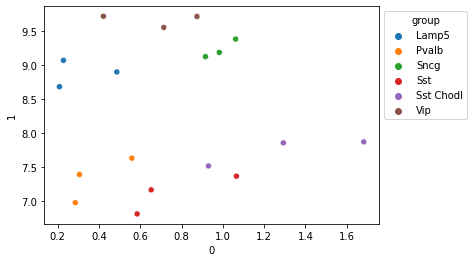

In [217]:
dt = df_proj_2d[df_proj_2d['classt'] == 'GABAergic']
ax=sns.scatterplot(
    dt[0],dt[1],
    hue=dt['group'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


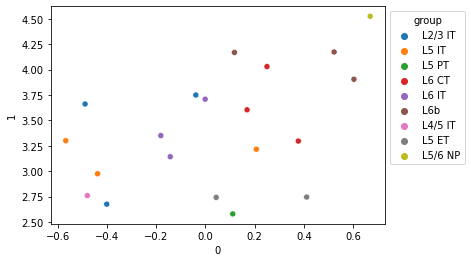

In [218]:
dt = df_proj_2d[df_proj_2d['classt'] == 'Glutamatergic']
ax=sns.scatterplot(
    dt[0],dt[1],
    hue=dt['group'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


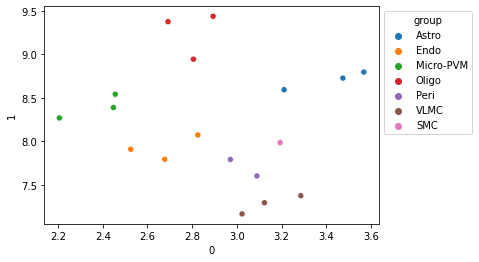

In [219]:
dt = df_proj_2d[df_proj_2d['classt'] == 'Other']
ax=sns.scatterplot(
    dt[0],dt[1],
    hue=dt['group'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))